In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from scipy.spatial import distance
from sklearn.manifold import TSNE

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
def plot_clusters(X, model, fit_predict):
    # funkcja przedstawiająca wizualizację zbioru danych w 3 wymiarach (pierwsze 3 kolumny)
    # kolorem zaznaczone są klastry przewidziane za pomocą zadanego modelu
    # argument fit_predict mówi, czy model ma metodę fit_predict, czy też predict

    if fit_predict:
        y_pred = model.fit_predict(X)
    else:
        y_pred = model.predict(X)

    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(90,0)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(0,90)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

def TSNE_scatter(tsne_model, model, data):
    # funkcja przedstawiająca wizualizację zbioru danych w 2 wymiarach za pomocą metody t-SNE

    x = tsne_model.fit_transform(data)
    colors = model.fit_predict(data)
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

# poniższe funkcje obliczają tzw. metryki interpretowalne
def count_clustering_scores(X, model, score_fun):
    X = X.to_numpy()
    model_instance = model
    labels = model_instance.fit_predict(X)

    return score_fun(X, labels)

def min_interclust_dist(X, label):
    # minimalny dystans pomiędzy klastrami

    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    # średni dystans pomiędzy obserwacjami w jednym klastrze

    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    # średnia z średniego dystansu pomiędzy obserwacjami w jednym klastrze obliczona
    # dla wszystkich klastrów

    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)


def std_dev_of_inclust_dist(X, label):
    # odchylenie standardowe ze średniej odległości pomiędzy punktami w jednym klastrze

    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)


def mean_dist_to_center(X, label):
    # średnia odległość od środka klastra

    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

def metrics_plots(data, max_k=10):
    # funkcja przedstawiająca wizualizację wyników 4 najpopularniejszych metryk pomocnych w doborze
    # liczby klastrów w modelu KMeans

    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(data)
        score.append(kmeans.score(data))
        score_kmeans_s.append(silhouette_score(data, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(data, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(data, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d]
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin']
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

In [3]:
df = pd.read_csv("../preprocessed_data/preprocessed_pca_train.csv")

# Kmeans

## Trening modelu, wizualizacje

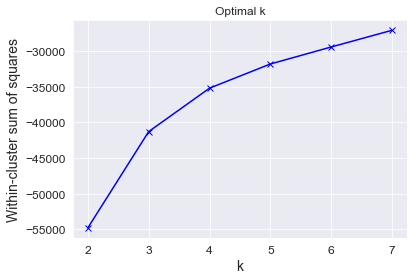

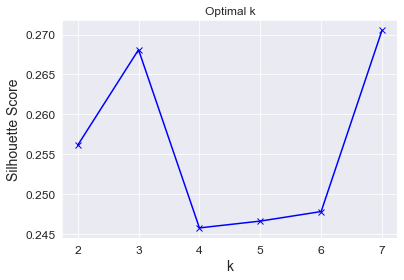

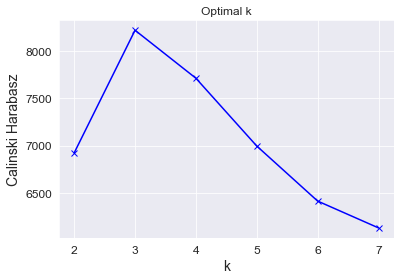

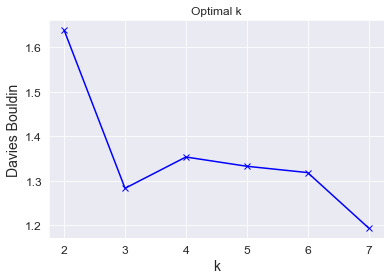

In [4]:
metrics_plots(df, max_k=8)

Powyższe metryki wskazują 3 jako dobrą liczbę klastrów

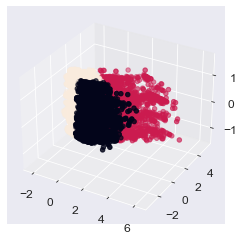

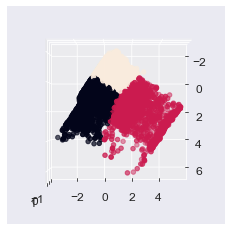

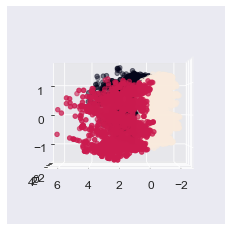

In [5]:
plot_clusters(df, KMeans(n_clusters=3, random_state=42), True)

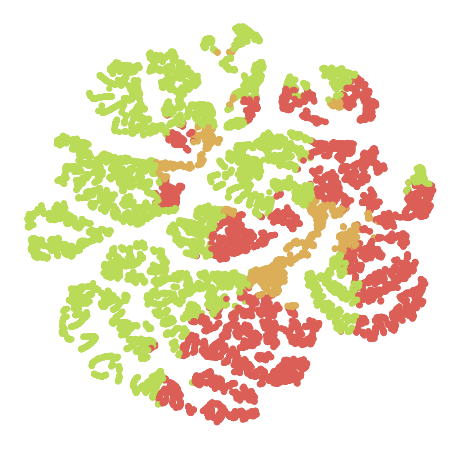

In [6]:
TSNE_scatter(TSNE(n_components=2, random_state=42), KMeans(n_clusters=3, random_state=42), df)

## Wyniki metryk interpretowalnych

In [159]:
metrices = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

models = {
    'KMeans_n_clusters=2': KMeans(n_clusters=2, random_state=42),
    'KMeans_n_clusters=3': KMeans(n_clusters=3, random_state=42),
    'KMeans_n_clusters=4': KMeans(n_clusters=4, random_state=42)
}

res = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        res.loc[model_key, metric_key] = count_clustering_scores(X=df, model=models[model_key],
                                                                score_fun=metrices[metric_key])
res

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
KMeans_n_clusters=2,0.013407,2.059375,0.267409,1.472819,0.256114
KMeans_n_clusters=3,0.036646,2.045672,0.411767,1.477981,0.268103
KMeans_n_clusters=4,0.030521,1.836166,0.469823,1.326794,0.245756


Otrzymujemy podobne rezultaty dla liczby klastrów 2 i 3.

## Interpretation

In [7]:
clusters = KMeans(n_clusters=3, random_state=42).fit_predict(df)
row_data = pd.read_csv("../data/train.csv")
res_df = row_data.join(pd.DataFrame({'cluster':clusters}))

Dyskretyzujemy wiek i roczny bilans dochodu w celu wizualizacji

In [8]:
def age_group(age):
    if 18 <= age <= 25:
        return '18-25'
    if 25 < age <= 40:
        return '25-40'
    if 40 < age <= 55:
        return '40-55'
    if 55 < age <= 70:
        return '55-70'
    return '70+'
res_df['age'] = res_df['age'].apply(lambda x: age_group(x))

In [9]:
def balance_group(balance):
    if balance < -2000:
        return '-20000:-2000'
    if -2000 <= balance < -1000:
        return '-2000:-1000'
    if -1000 <= balance < 0:
        return '-1000:0'
    if balance == 0:
        return '0'
    if 0 < balance < 1000:
        return '0:1000'
    if 1000 <= balance < 2000:
        return '1000:2000'
    if 2000 <= balance < 4000:
        return '2000:4000'
    if 4000 <= balance < 10000:
        return '4000:10000'
    return '10000:100000'
res_df['balance'] = res_df['balance'].apply(lambda x: balance_group(x))

In [10]:
res_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster
0,25-40,admin.,single,secondary,no,0:1000,no,no,cellular,29,jan,171,1,-1,0,unknown,no,2
1,40-55,services,married,secondary,yes,0,no,no,telephone,31,jul,35,9,-1,0,unknown,no,0
2,55-70,entrepreneur,married,secondary,no,0:1000,yes,yes,unknown,16,jun,345,4,-1,0,unknown,no,0
3,55-70,technician,married,secondary,no,4000:10000,no,no,telephone,9,feb,167,1,469,1,success,no,1
4,25-40,blue-collar,single,secondary,no,0:1000,no,no,cellular,21,nov,116,1,-1,0,unknown,no,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22147,40-55,management,single,tertiary,no,1000:2000,yes,no,cellular,17,apr,77,1,268,4,other,no,2
22148,40-55,management,single,tertiary,no,2000:4000,yes,no,cellular,18,oct,310,1,804,1,failure,yes,2
22149,25-40,management,married,tertiary,no,-1000:0,yes,no,cellular,28,jan,230,1,204,1,other,no,2
22150,40-55,blue-collar,married,primary,no,0:1000,no,no,unknown,17,jun,114,17,-1,0,unknown,no,0


In [11]:
# liczności klastrów
res_df.cluster.value_counts()

2    12297
0     8277
1     1578
Name: cluster, dtype: int64

In [14]:
def draw_bar_plots_per(data):
    # funkcja przedstawiająca procentowy udział obserwacji pogrupowanych w klastry dla wybranych zmiennych

    clusters = data.cluster
    columns = ['age', 'balance', 'job', 'education', 'marital', 'default', 'housing', 'loan']

    for column in columns:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        counts = data.groupby([column, clusters]).size().unstack()
        proportions = counts.apply(lambda x: x / x.sum(), axis=1)
        proportions.plot(kind='bar', ax=ax)
        plt.show()

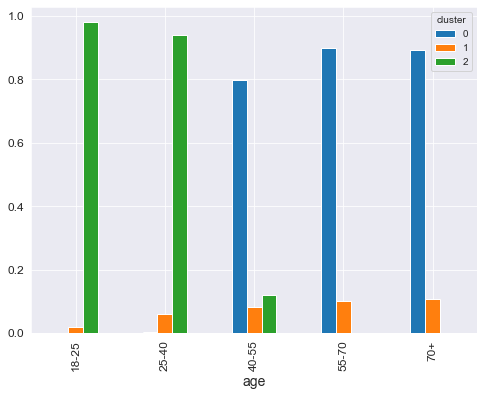

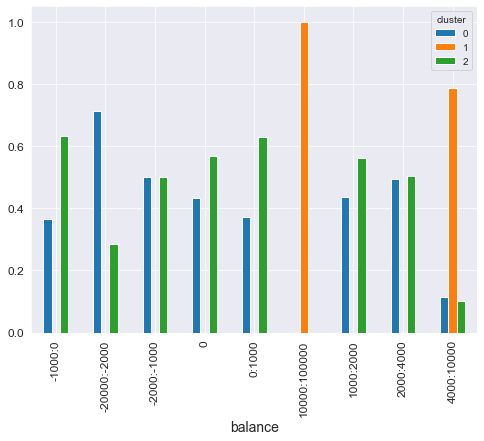

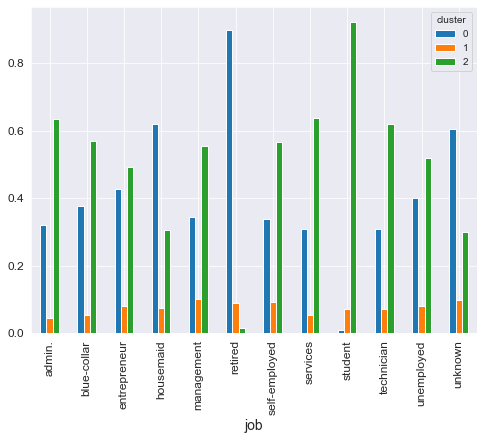

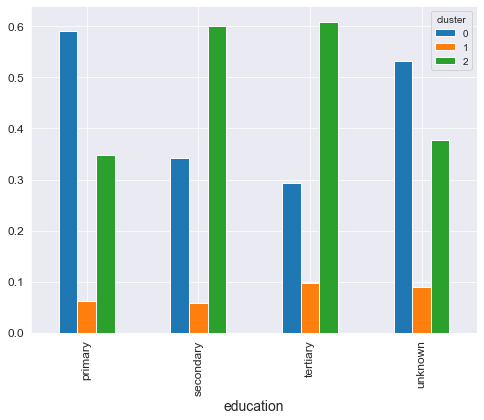

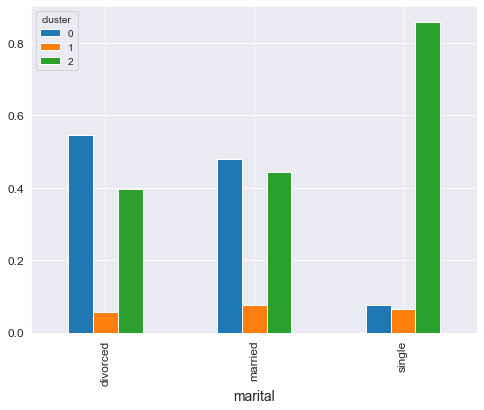

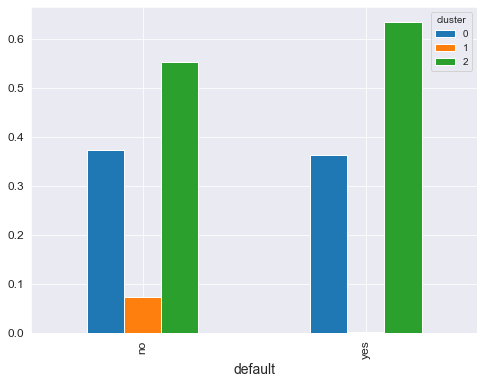

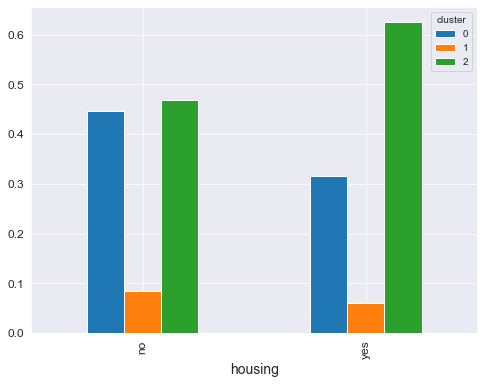

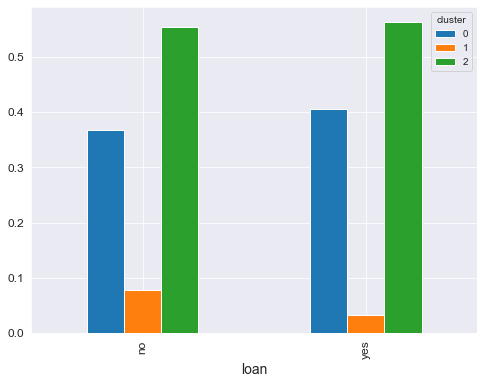

In [13]:
draw_bar_plots_per(res_df)

# Podsumowanie

Niestety pomimo dobrych wyników metryk model KMeans nie pozwolił nam na zdefiniowanie wyraźnych różnic pomiędzy obserwacjami znajdującymi się w różnych klastrach. Nie przeprowadzamy wobec tego analizy wyników modelu na danych testowych.